## Raven Memory benchmarking

The following is meant to observe the memory performance in a more verbose logging mode, for the baseline raven models

## Setup

In [ ]:
# Due to the size of the CSV data, we did not include it in the repository. You can download our current CSV data from hugging face
!mkdir -p ./logs

# Raven models
!cd ./logs && wget -nc https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/Raven-1B5-v12.csv
!cd ./logs && wget -nc https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/Raven-3B-v12.csv
!cd ./logs && wget -nc https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/Raven-7B-v12.csv

# Experimental RWKv4neo models
!cd ./logs && wget -nc https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/Echo-B-1B4-Tune3-L96-D1024.csv
!cd ./logs && wget -nc https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/TokenShift-A-Tune4.csv

In [ ]:
# Install required pip libraries
!python -m pip install matplotlib

## Loading of CSV data

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 50)

# Load the CSV data
raven_1b5 = pd.read_csv("./logs/Raven-1B5-v12.csv")
raven_3b  = pd.read_csv("./logs/Raven-3B-v12.csv")
raven_7b  = pd.read_csv("./logs/Raven-7B-v12.csv")

echoB_1b4  = pd.read_csv("./logs/Echo-B-1B4-Tune3-L96-D1024.csv")
tshiftA_1B3  = pd.read_csv("./logs/TokenShift-A-Tune4.csv")


In [44]:
# Define a custom function to calculate averages for the first N elements
def calculate_first_n_avg(n, s):
    return s.iloc[:n].mean()

# Groupby the 'eval_token_count' and calculate the average for the first 5, 10, and 20 'eval_token_pos'
def group_csv_data(inCSV, modelName):
    grouped_data = inCSV.groupby(['eval_token_count', 'is_random_baseline']).apply(lambda x: pd.Series({
        'First 1 tokens average': calculate_first_n_avg(1, x['eval_token_pos']),
        'First 2 tokens average': calculate_first_n_avg(2, x['eval_token_pos']),
        'First 5 tokens average': calculate_first_n_avg(5, x['eval_token_pos']),
        'First 10 tokens average': calculate_first_n_avg(10, x['eval_token_pos']),
        'First 25 tokens average': calculate_first_n_avg(25, x['eval_token_pos']),
        'First 50 tokens average': calculate_first_n_avg(50, x['eval_token_pos']),
        'First 100 tokens average': calculate_first_n_avg(100, x['eval_token_pos']),
        'First 250 tokens average': calculate_first_n_avg(250, x['eval_token_pos']),
        'First 500 tokens average': calculate_first_n_avg(500, x['eval_token_pos']),
        'First 750 tokens average': calculate_first_n_avg(750, x['eval_token_pos']),
        'First 1000 tokens average': calculate_first_n_avg(1000, x['eval_token_pos'])
    })).reset_index()
    grouped_data['model'] = modelName
    return grouped_data

# Merge the DataFrames 
full_grouped_data = pd.concat([
    group_csv_data(raven_1b5, 'Raven 1B5'),
    group_csv_data(raven_3b, 'Raven 3B'),
    group_csv_data(raven_7b, 'Raven 7B'),

    group_csv_data(echoB_1b4, 'EchoB 1B4 (L96)'),
    group_csv_data(tshiftA_1B3, 'TokenShiftA 1B4 (L12)'),
])

# Plot the data
full_grouped_data

,eval_token_count,is_random_baseline,First 1 tokens average,First 2 tokens average,First 5 tokens average,First 10 tokens average,First 25 tokens average,First 50 tokens average,First 100 tokens average,First 250 tokens average,First 500 tokens average,First 750 tokens average,First 1000 tokens average,model
0,5,False,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Raven 1B5
1,10,False,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Raven 1B5
2,15,False,0.0,0.0,0.0,0.0,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,Raven 1B5
3,20,False,0.0,0.0,0.0,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,Raven 1B5
4,25,False,0.0,0.0,0.0,0.0,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,Raven 1B5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,850,False,0.0,0.0,0.0,0.0,0.080000,0.200000,0.240000,0.956000,7.638000,25.008000,31.072941,TokenShiftA 1B4 (L12)
64,900,False,0.0,0.0,0.0,0.0,0.080000,0.200000,0.260000,0.964000,7.736000,28.080000,44.554444,TokenShiftA 1B4 (L12)
65,950,False,0.0,0.0,0.0,0.0,0.080000,0.220000,0.310000,0.884000,7.610000,28.024000,82.608421,TokenShiftA 1B4 (L12)
66,1000,False,0.0,0.0,0.0,0.0,0.080000,0.240000,0.330000,1.004000,7.878000,29.390667,121.732000,TokenShiftA 1B4 (L12)


In [54]:
# We get the position values, of the average token prediction, withou ONLY the output.
# this helps get the approximate "random" score baseline, while accounting for the fact that the model may eventually notice patterns that makes it not truely random
# (eg. no special characters, etc), as the sample grows.

# Filter out for noise baseline
random_baseline = full_grouped_data[full_grouped_data['is_random_baseline'] == True]

# Geet the average first 1000 tokens for all models
random_baseline_pos = random_baseline.groupby(['model']).mean()['First 1000 tokens average']["Raven 1B5"]
half_random_base_line_pos = random_baseline_pos / 2

print("random_baseline_pos", random_baseline_pos)
print("half_random_base_line_pos", half_random_base_line_pos)

# Get the specialize model randomized baseline
special_random_baseline_pos = random_baseline.groupby(['model']).mean()['First 1000 tokens average']["EchoB 1B4 (L96)"]
special_half_random_base_line_pos = special_random_baseline_pos / 2

print("special_random_baseline_pos", special_random_baseline_pos)
print("special_half_random_base_line_pos", special_half_random_base_line_pos)

# Give the randomized baseline values
random_baseline

random_baseline_pos 1665.979
half_random_base_line_pos 832.9895
special_random_baseline_pos 942.793
special_half_random_base_line_pos 471.3965


,eval_token_count,is_random_baseline,First 1 tokens average,First 2 tokens average,First 5 tokens average,First 10 tokens average,First 25 tokens average,First 50 tokens average,First 100 tokens average,First 250 tokens average,First 500 tokens average,First 750 tokens average,First 1000 tokens average,model
66,1000,True,1188.0,597.0,5775.4,3777.9,2974.16,2219.60,1830.49,1808.140,1705.120,1693.132000,1665.979,Raven 1B5
66,1000,True,1813.0,910.5,4843.8,3640.0,2973.68,2270.46,1834.36,1873.672,1759.384,1718.648000,1661.297,Raven 3B
66,1000,True,1159.0,592.0,1804.0,2224.3,2468.96,2062.82,1724.78,1842.436,1700.870,1678.028000,1628.807,Raven 7B
67,1000,True,3897.0,1949.5,1512.4,1242.2,1034.80,972.60,941.56,930.616,924.262,933.157333,942.793,EchoB 1B4 (L96)
67,1000,True,1426.0,973.0,1767.0,1457.3,1384.68,1146.72,1134.52,1073.604,1036.906,1011.653333,984.150,TokenShiftA 1B4 (L12)


In [57]:
def plotGrapData(sizeArr=[2], redline=False):
    # Lets join the size array, to a single str for logging
    sizeStr = ", ".join([str(x) for x in sizeArr])

    # Plot the axis
    fig, ax = plt.subplots(figsize=(15,7)) #
    ax.set_title(f'First {sizeStr} tokens average for each model')
    ax.set_xlabel('Token count')
    ax.set_ylabel('Average token position')

    # Plot the data, excluding is random baseline = true
    for key, grp in full_grouped_data[full_grouped_data['is_random_baseline'] == False].groupby('model'):
        ax = grp.plot(
            ax=ax, kind='line', x='eval_token_count', 
            y=f'First {sizeArr[0]} tokens average', 
            label=f'{key} - First {sizeArr[0]} tokens average'
        )

        if len(sizeArr) >= 2:
            ax = grp.plot(
                ax=ax, kind='line', x='eval_token_count',
                y=f'First {sizeArr[1]} tokens average', 
                label=f'{key} - First {sizeArr[1]} tokens average', linestyle='dashed'
            )

        if len(sizeArr) >= 3:
            ax = grp.plot(ax=ax, kind='line', x='eval_token_count', 
                          y=f'First {sizeArr[2]} tokens average', 
                          label=f'{key} - First {sizeArr[2]} tokens average', linestyle='dotted'
            )

    # Add redline if set
    if redline != False:
        ax.axhline(y=half_random_base_line_pos, color='r', linestyle='-.', label='50 percent of Raven Randomized baseline')
        ax.axhline(y=special_half_random_base_line_pos, color='r', linestyle=':', label='50 percent of Specialized Model Randomized baseline')


    # Include grid lines - with major, and minor grid
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.5')
    ax.grid(which='minor', linestyle=':', linewidth='0.5')

## Plotting of high level data

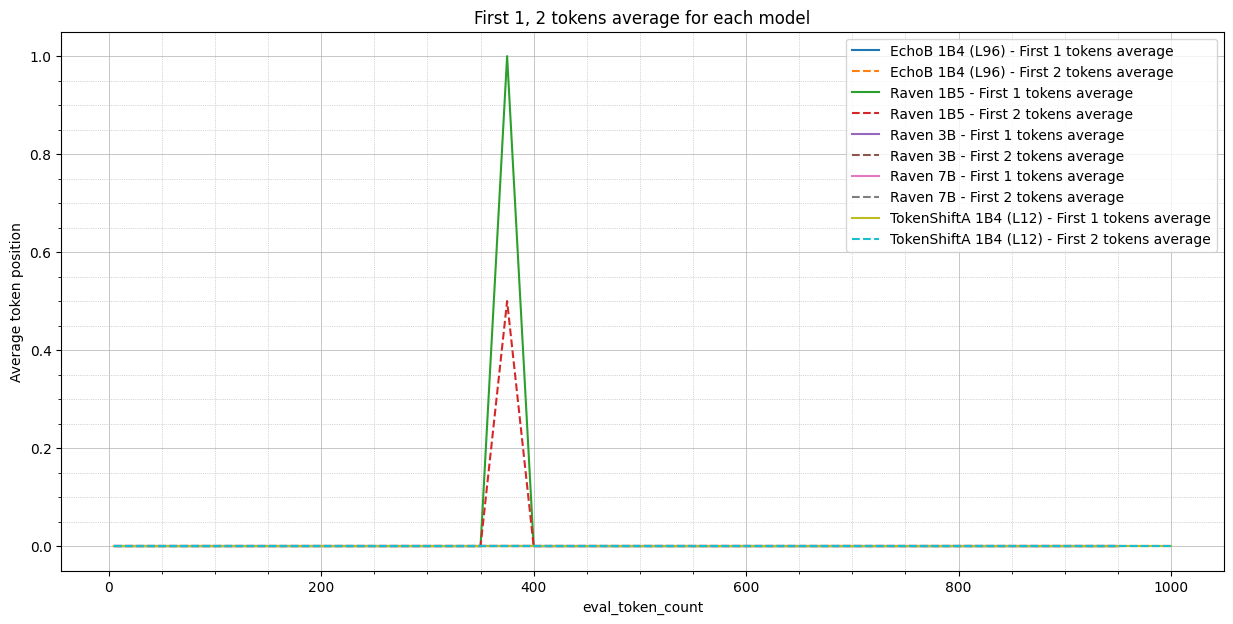

In [47]:
# Lets chart the first 1 & 2 tokens average for each model
plotGrapData([1,2])

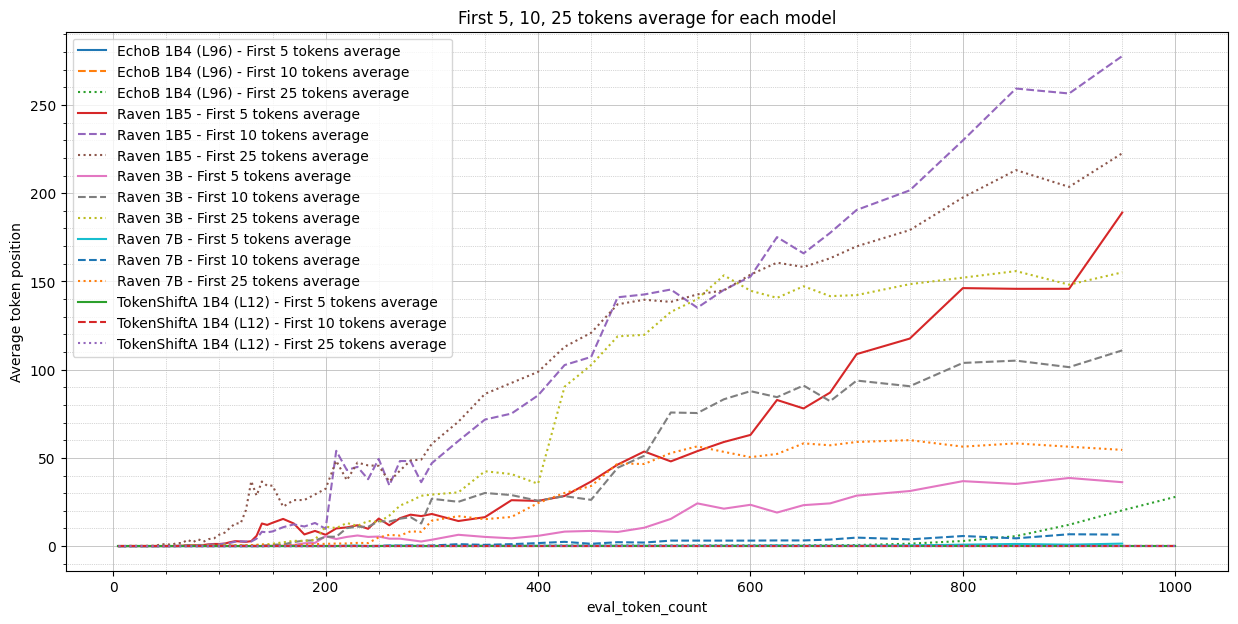

In [48]:
# Lets chart the first 5,10,25 tokens average for each model
plotGrapData([5,10,25])

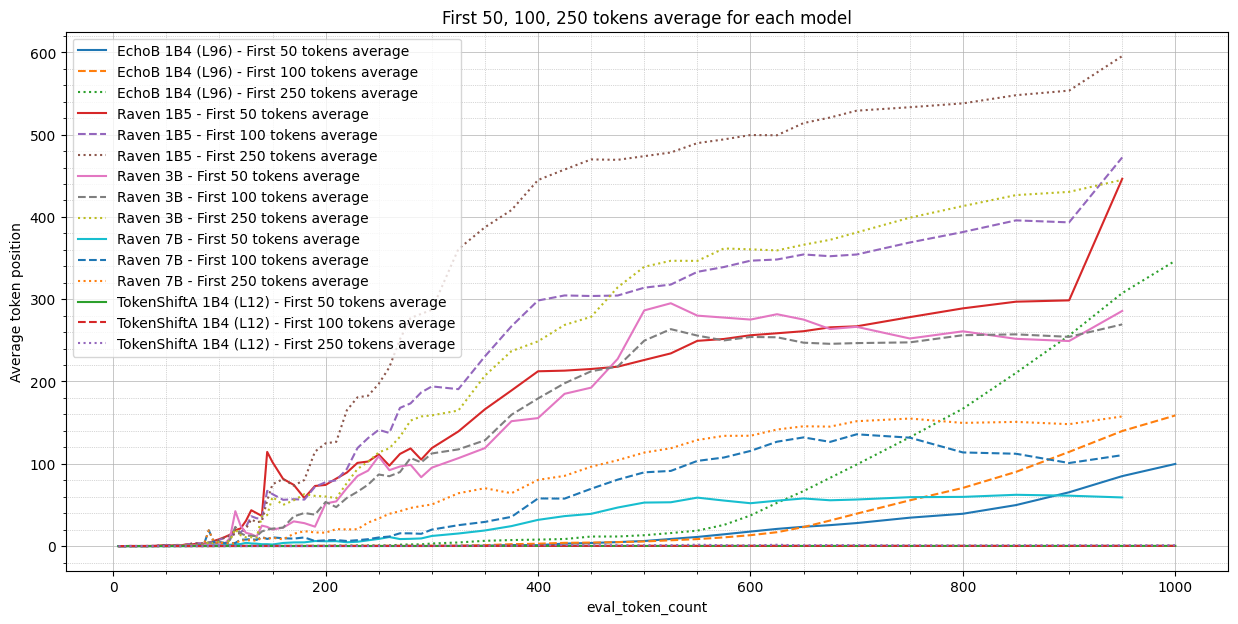

In [49]:
# Lets chart the first 50,100,250 tokens average for each model
plotGrapData([50,100,250])

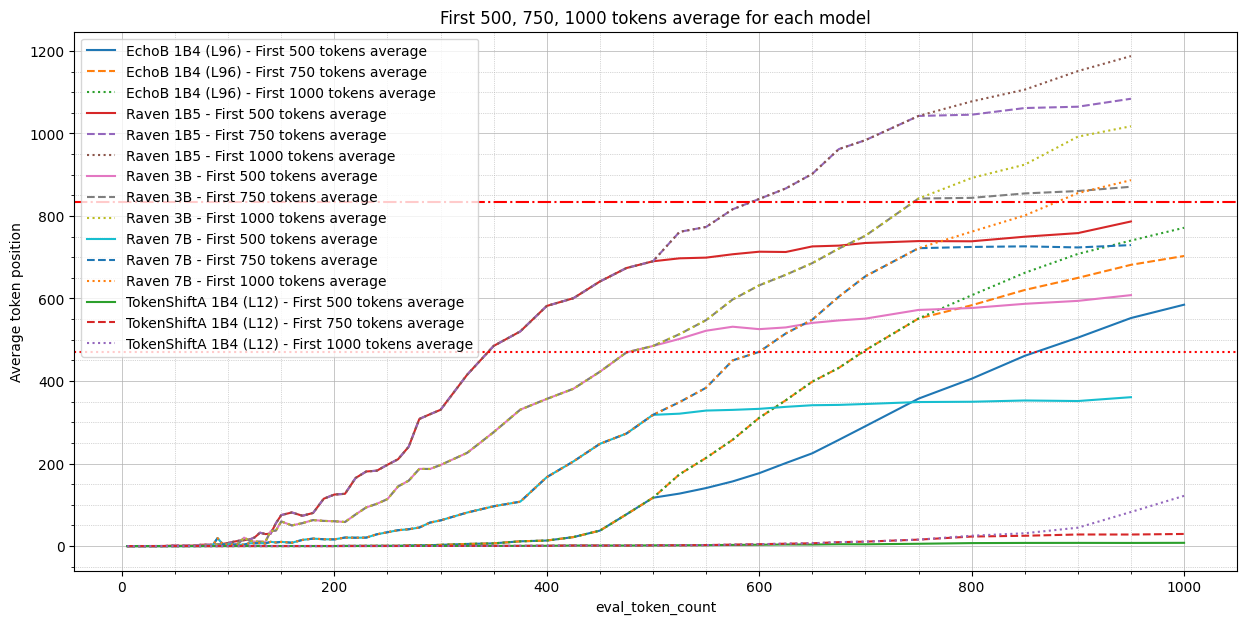

In [58]:
# Lets chart the first 500,750,1000 tokens average for each model
plotGrapData([500,750,1000], redline=True)

## Plotting of focused data points

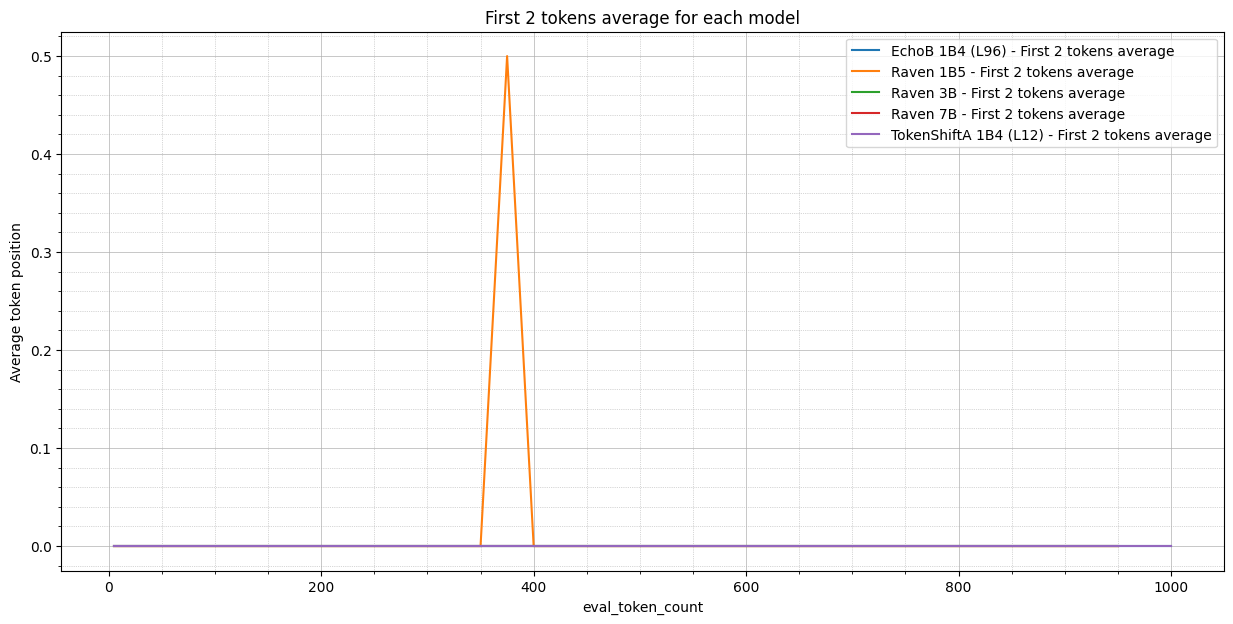

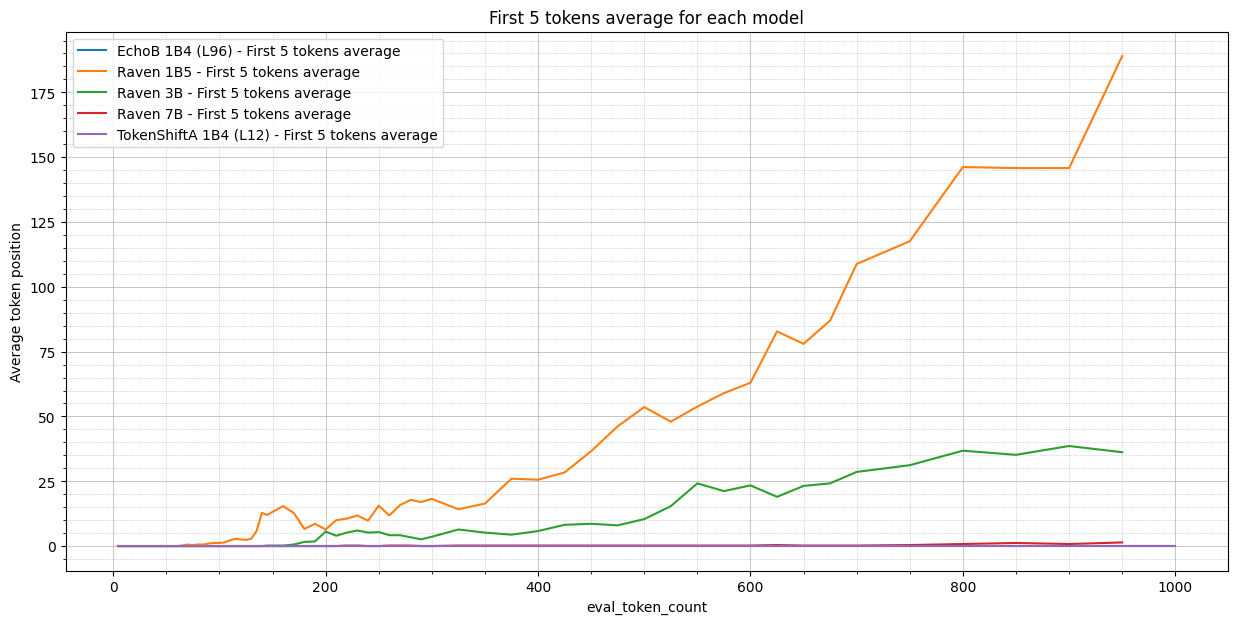

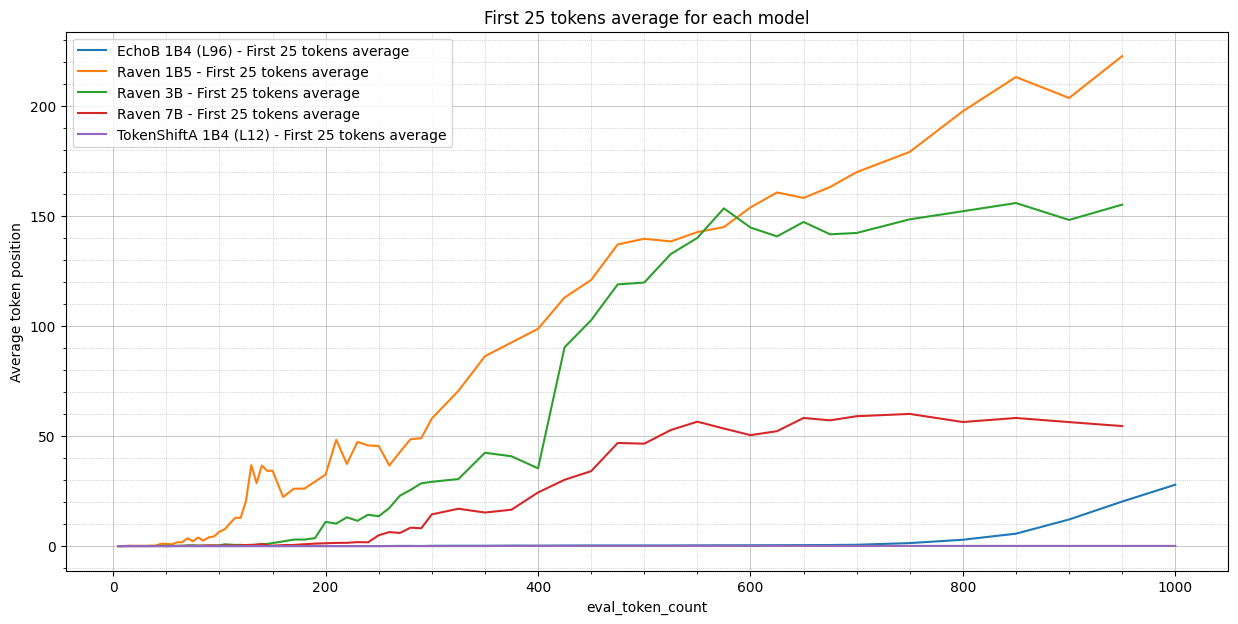

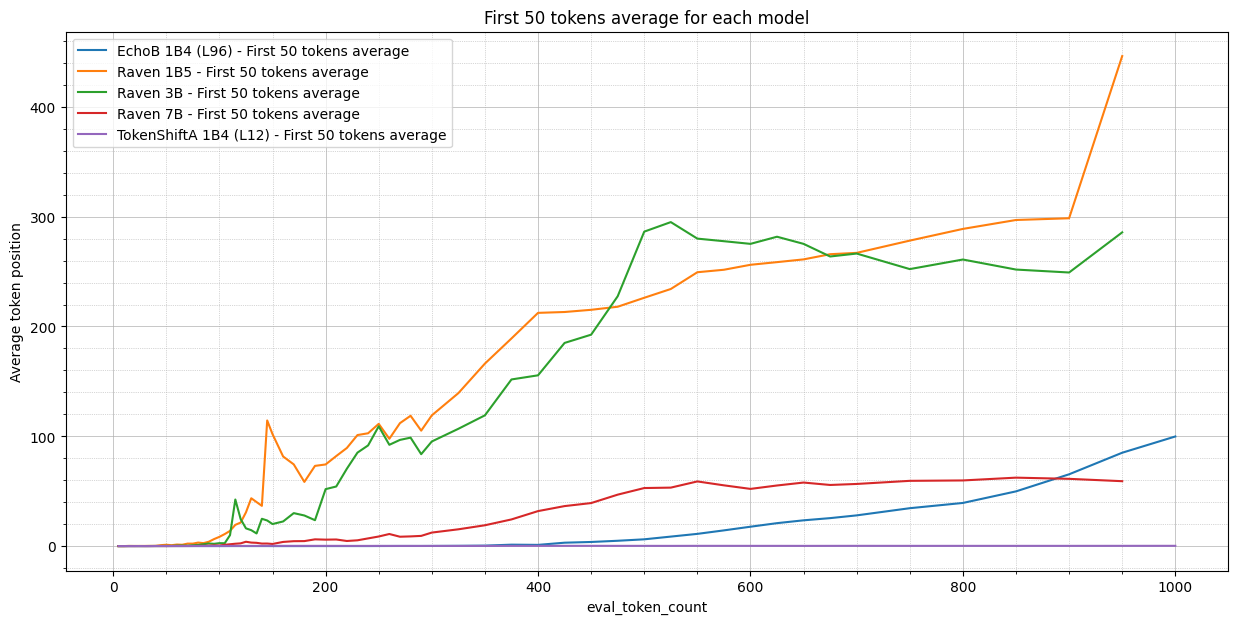

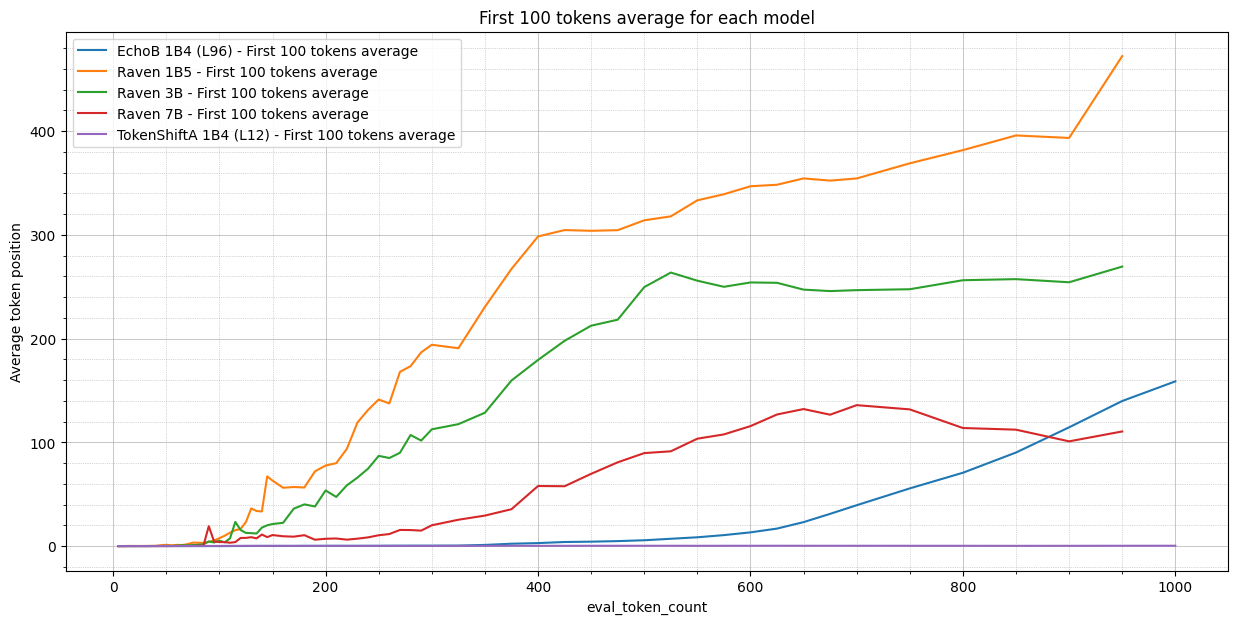

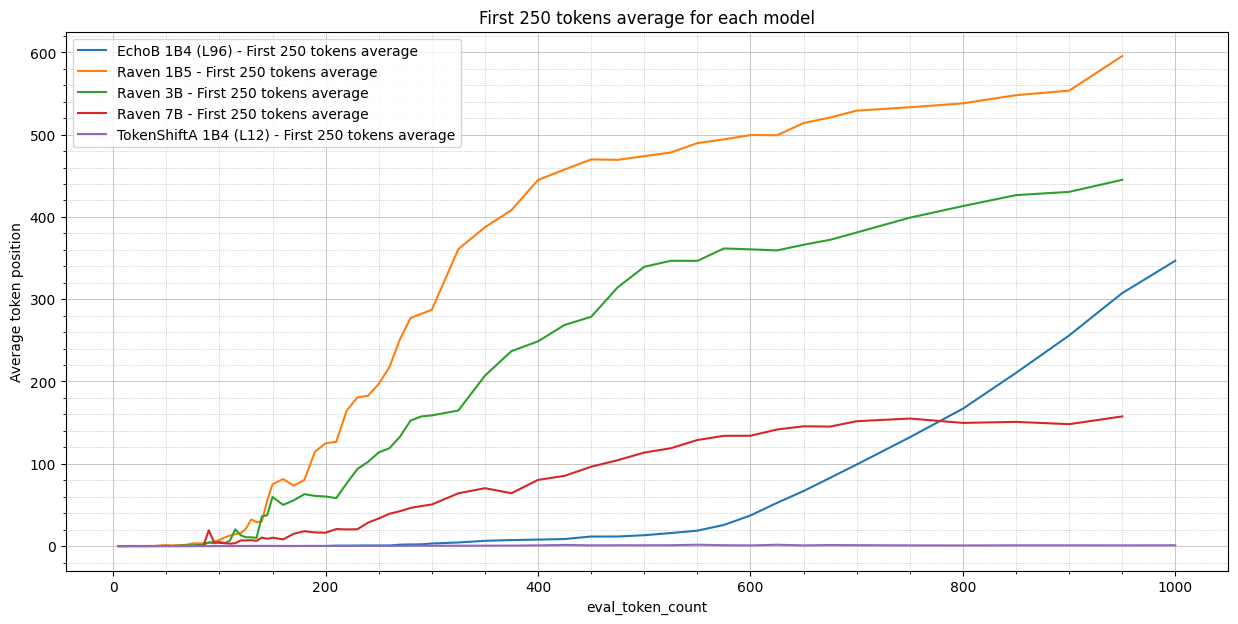

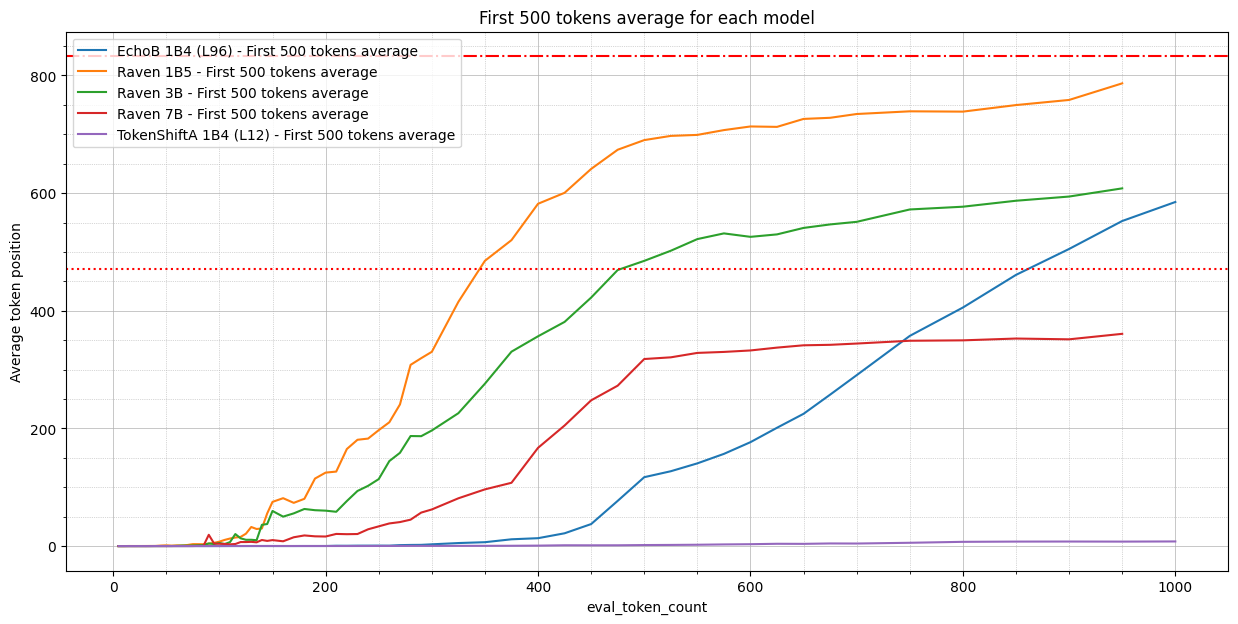

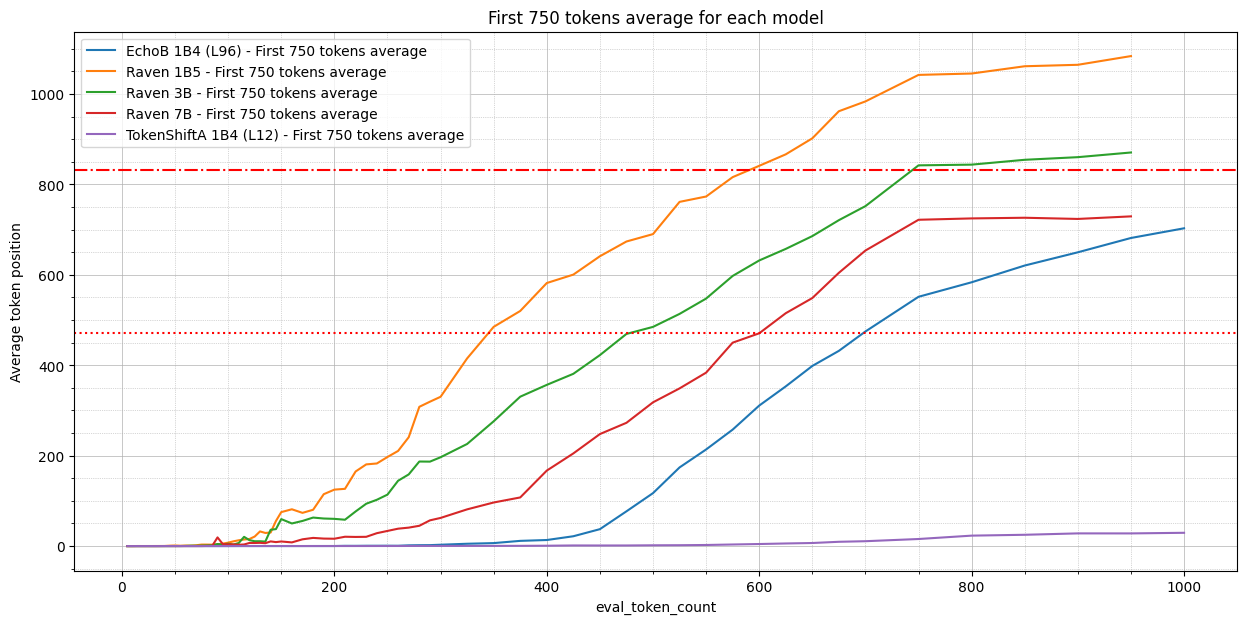

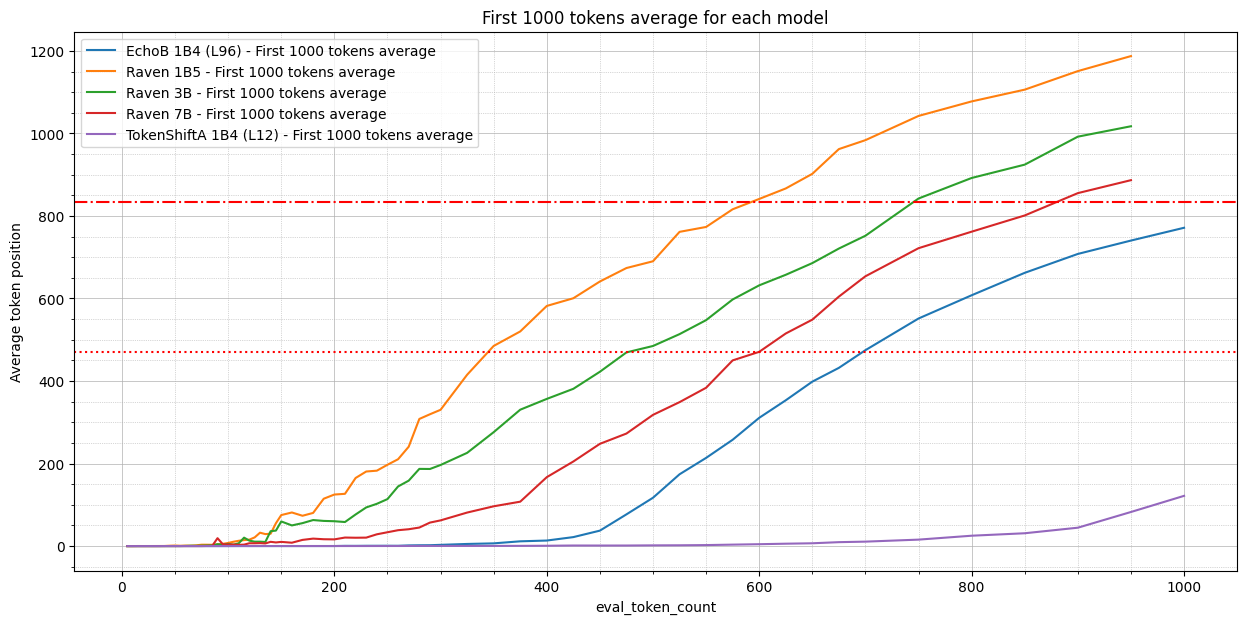

In [59]:
# Lets chart the first 2 tokens average for each model
plotGrapData([2])
plotGrapData([5])
plotGrapData([25])
plotGrapData([50])
plotGrapData([100])
plotGrapData([250])
plotGrapData([500], redline=True)
plotGrapData([750], redline=True)
plotGrapData([1000], redline=True)